In [1]:
import csv 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime
import math
import pytz
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from statsmodels.api import OLS
from sklearn.metrics import r2_score, mean_squared_error

# Question 3

In [51]:
#build a feature map dataframe with 5 features, from left to right are total number of tweets, total num of followers, 
#total num of retweets, maximum num of followers and time
def readfile_lr(file_name):
    with open(file_name,encoding='utf8') as file:
        #Each line is a tweet info
        data=file.readlines()
    time_list=[]
    num_followers=[]
    num_retweets=[]
    for line in data:
        json_object=json.loads(line)
        time_list.append(json_object['citation_date'])#extract time a tweet is posted by
        num_followers.append(json_object['author']['followers'])#extract number of followers of teh person tweeting
        num_retweets.append(json_object['metrics']['citations']['total'])#extract number of retweets of a tweet
    file.close()
    date_list=[]
    pst_tz=pytz.timezone('America/Los_Angeles')#time info conversion
    for time in time_list:
        date=datetime.datetime.fromtimestamp(time,pst_tz).replace(tzinfo=None)
        date_list.append(date)#save converted time into a new list
    df=pd.DataFrame(date_list,columns=['Date'])#generate a dataframe based on date
    df=df.set_index(df['Date'])#set a date string as index
    #print(date_df)
    df.drop(['Date'],'columns',inplace=True)#discard the second column
    df['num_tweets']=1#initialize a new column and set the column name as num_tweets
    df['num_followers']=num_followers
    df['num_retweets']=num_retweets
    feature_map=df.resample('H').sum()#total number of tweets, total num_followers, total num_retweets
    feature_map['max_followers']=df['num_followers'].resample('H').max()#pick maximum num of followers and resample
    feature_map['time']=feature_map.index.hour#extract hour index from 0 to 23
    
    return feature_map#return the entire feature map in dataframe format

#implement OLS function
def ols(feature_map):
    #labels are the num_tweets in the next hour
    Y_train=feature_map['num_tweets'][1:]
    #Features are those five features in the previous hour, both labels and X_train data has length = samples-1
    X_train=feature_map.iloc[:-1]
    Y_train=np.nan_to_num(Y_train)#replace nan value into numeric value
    X_train=np.nan_to_num(X_train)
    model=OLS(Y_train,X_train)
    #model fitting
    results=model.fit()
    r2=r2_score(Y_train, results.fittedvalues)#get r2 score
    mse=mean_squared_error(Y_train,results.fittedvalues)#get mse score
    p_score=results.pvalues#get p_values
    index=np.argsort(p_score)#sort p_values from small to big
    sort_p_score=[]
    sort_feature_name=[]
    key_list=feature_map.keys()
    t_score=np.abs(results.tvalues)#get t_values and take absolute value
    index_t=np.flip(np.argsort(t_score))
    sort_t_score=[]
    sort_feature_name_t=[]
    for i in index:
        sort_p_score.append(p_score[i])
        sort_feature_name.append(key_list[i])
    for j in index_t:
        sort_t_score.append(t_score[j])
        sort_feature_name_t.append(key_list[j])
    return r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results
    

In [52]:
#gohawks
#extract feature map
feature_map=readfile_lr('tweets_#gohawks.txt')
feature_map

,num_tweets,num_followers,num_retweets,max_followers,time
Date,,,,,
2015-01-14 00:00:00,29,23814.0,459,12922.0,0
2015-01-14 01:00:00,13,7774.0,32,2592.0,1
2015-01-14 02:00:00,14,26891.0,378,11886.0,2
2015-01-14 03:00:00,9,19094.0,28,11886.0,3
2015-01-14 04:00:00,24,31949.0,62,9772.0,4
...,...,...,...,...,...
2015-02-06 22:00:00,4,288.0,6,120.0,22
2015-02-06 23:00:00,2,1616.0,2,1496.0,23
2015-02-07 00:00:00,0,0.0,0,NaN,0


In [7]:
#evaluation and analysis
r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols(feature_map)
print('For gohawks file')
print('The R-square score is\n {}'.format(r2))
print('The mean_square_error is\n {}'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}'.format(sort_feature_name))
print('The sorted features p value is\n {}'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

For gohawks file
The R-square score is
 0.47480860962966764
The mean_square_error is
 760963.8885815816
The sorted feature from the most important to the least important according to p value is
 ['num_tweets', 'num_retweets', 'time', 'num_followers', 'max_followers']
The sorted features p value is
 [2.1558340030500642e-14, 0.0016094751255168772, 0.01046191053645082, 0.015236905344201529, 0.631486218689876]
The sorted feature from the most important to the least important according to t value is
 ['num_tweets', 'num_retweets', 'time', 'num_followers', 'max_followers']
The sorted features t value is
 [7.843378151478332, 3.169317614557552, 2.568640890438078, 2.434013268666322, 0.47989354717109556]


In [8]:
#gopatriots
#extract feature map
feature_map=readfile_lr('tweets_#gopatriots.txt')
#evaluation and analysis
r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols(feature_map)
print('For gopatriots file')
print('The R-square score is\n {}'.format(r2))
print('The mean_square_error is\n {}'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}'.format(sort_feature_name))
print('The sorted features p value is\n {}'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

For gopatriots file
The R-square score is
 0.6290492173174211
The mean_square_error is
 27610.106513684317
The sorted feature from the most important to the least important according to p value is
 ['num_retweets', 'num_tweets', 'time', 'num_followers', 'max_followers']
The sorted features p value is
 [0.009419548144866697, 0.27931161073520777, 0.4714206412129177, 0.5796288031443038, 0.953971418389757]
The sorted feature from the most important to the least important according to t value is
 ['num_retweets', 'num_tweets', 'time', 'num_followers', 'max_followers']
The sorted features t value is
 [2.6052992829103236, 1.0828997275701087, 0.7206503192966136, 0.5542452077888393, 0.057745757094862606]


In [9]:
#nfl
#extract feature map
feature_map=readfile_lr('tweets_#nfl.txt')
#evaluation and analysis
r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols(feature_map)
print('For nfl file')
print('The R-square score is\n {}'.format(r2))
print('The mean_square_error is\n {}'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}'.format(sort_feature_name))
print('The sorted features p value is\n {}'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

For nfl file
The R-square score is
 0.5646971826259619
The mean_square_error is
 273848.2764738912
The sorted feature from the most important to the least important according to p value is
 ['num_tweets', 'num_followers', 'time', 'max_followers', 'num_retweets']
The sorted features p value is
 [2.9904419649571815e-06, 2.4286553288989783e-05, 0.00013003626405635996, 0.0024861084400131257, 0.004794168427464391]
The sorted feature from the most important to the least important according to t value is
 ['num_tweets', 'num_followers', 'time', 'max_followers', 'num_retweets']
The sorted features t value is
 [4.717747657166747, 4.2557593364134, 3.8522980061351255, 3.0382930424486414, 2.8314560291081516]


In [10]:
#patriots
#extract feature map
feature_map=readfile_lr('tweets_#patriots.txt')
#evaluation and analysis
r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols(feature_map)
print('For patriots file')
print('The R-square score is\n {}'.format(r2))
print('The mean_square_error is\n {}'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}'.format(sort_feature_name))
print('The sorted features p value is\n {}'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

For patriots file
The R-square score is
 0.6678757037266486
The mean_square_error is
 5189462.115467411
The sorted feature from the most important to the least important according to p value is
 ['num_tweets', 'max_followers', 'num_retweets', 'time', 'num_followers']
The sorted features p value is
 [7.594597943354794e-34, 0.13706545617709381, 0.24260708193742175, 0.5057830851778553, 0.6606514226819942]
The sorted feature from the most important to the least important according to t value is
 ['num_tweets', 'max_followers', 'num_retweets', 'time', 'num_followers']
The sorted features t value is
 [12.942668856808517, 1.4888651773090238, 1.1696857151788445, 0.665831471562618, 0.43923935532659375]


In [11]:
#sb49
#extract feature map
feature_map=readfile_lr('tweets_#sb49.txt')
#evaluation and analysis
r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols(feature_map)
print('For sb49 file')
print('The R-square score is\n {}'.format(r2))
print('The mean_square_error is\n {}'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}'.format(sort_feature_name))
print('The sorted features p value is\n {}'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

For sb49 file
The R-square score is
 0.804456014699212
The mean_square_error is
 16199530.45268142
The sorted feature from the most important to the least important according to p value is
 ['num_tweets', 'max_followers', 'num_retweets', 'num_followers', 'time']
The sorted features p value is
 [2.955059757275547e-34, 0.02270359216001565, 0.040014471081590015, 0.4297124294462823, 0.8127545887975135]
The sorted feature from the most important to the least important according to t value is
 ['num_tweets', 'max_followers', 'num_retweets', 'num_followers', 'time']
The sorted features t value is
 [13.041985270251567, 2.2845133355326794, 2.0582519487800703, 0.7902397278446034, 0.2369823576506898]


# Feature Analysis
# Question 4 & Question 5
Features: num_tweets, num/max followers,num/max retweets, num/max replies, num/max mentions, num/max urls, num/max hastags, num/max favorites, num/max impressions, num/max rank, author

In [54]:
#additional features
def readfile_lr_morefeatures(file_name):
    with open(file_name,encoding='utf8') as file:
        #Each line is a tweet info
        data=file.readlines()
    time_list=[]
    num_followers=[]
    num_retweets=[]
    num_replies=[]
    num_mentions=[]
    mentions_ratio=[]
    num_urls=[]
    urls_ratio=[]
    num_hashtags=[]
    hashtags_ratio=[]
    num_favorites=[]
    num_impressions=[]
    num_rank=[]
    author=[]
    for line in data:
        json_object=json.loads(line)
        time_list.append(json_object['citation_date'])#extract time a tweet is posted by
        num_followers.append(json_object['author']['followers'])#extract number of followers of teh person tweeting
        num_retweets.append(json_object['metrics']['citations']['total'])#extract number of retweets of a tweet
        num_replies.append(json_object['metrics']['citations']['replies'])#extract number of replies
        num_mentions.append(len(json_object['tweet']['entities']['user_mentions']))#extract number of mentions (length of the list)
        mentions_ratio.append(len(json_object['tweet']['entities']['user_mentions'])/len(json_object['tweet']['text']))#extract ration of mentions
        num_urls.append(len(json_object['tweet']['entities']['urls']))#extract number of urls
        urls_ratio.append(len(json_object['tweet']['entities']['urls'])/len(json_object['tweet']['text']))#extract ratio of urls
        num_hashtags.append(len(json_object['tweet']['entities']['hashtags']))#extract number of hastages
        hashtags_ratio.append(len(json_object['tweet']['entities']['hashtags'])/len(json_object['tweet']['text']))#extract ratio of hastages
        num_favorites.append(json_object['tweet']['favorite_count'])
        num_impressions.append(json_object['metrics']['impressions'])
        num_rank.append(json_object['metrics']['ranking_score'])
        author.append(json_object['author']['name'])
    file.close()
    date_list=[]
    pst_tz=pytz.timezone('America/Los_Angeles')#time info conversion
    for time in time_list:
        date=datetime.datetime.fromtimestamp(time,pst_tz).replace(tzinfo=None)
        date_list.append(date)#save converted time into a new list
    date_df=pd.DataFrame(date_list,columns=['Date'])#generate a dataframe based on date
    date_df=date_df.set_index(date_df['Date'])#set a date string as index
    #print(date_df)
    date_df.drop(['Date'],'columns',inplace=True)#discard the second column
    date_df['num_tweets']=1 #initialize a new column and set the column name as num_tweets
    date_df['num_followers']=num_followers
    date_df['num_retweets']=num_retweets
    date_df['num_replies']=num_replies
    date_df['num_mentions']=num_mentions
    date_df['num_urls']=num_urls
    date_df['num_hashtags']=num_hashtags
    date_df['num_favorites']=num_favorites
    date_df['num_impressions']=num_impressions
    date_df['num_rank']=num_rank
    date_df['author']=author
    feature_map=date_df.resample('H').sum()#total number of tweets, total num_followers, total num_retweets, replies, mentions, urls, hashtags
    #date_df['mentions_ratio']=mentions_ratio
    #date_df['urls_ratio']=urls_ratio
    #date_df['hashtags_ratio']=hashtags_ratio
    feature_map['max_followers']=date_df['num_followers'].resample('H').max()#pick maximum num of followers and resample
    feature_map['max_replies']=date_df['num_replies'].resample('H').max()
    feature_map['max_mentions']=date_df['num_mentions'].resample('H').max()
    feature_map['max_urls']=date_df['num_urls'].resample('H').max()
    feature_map['max_hashtags']=date_df['num_hashtags'].resample('H').max()
    #feature_map['mentions_ratio']=date_df['mentions_ratio'].resample('H').mean()
    #feature_map['urls_ratio']=date_df['urls_ratio'].resample('H').mean()
    #feature_map['hashtags_ratio']=date_df['hashtags_ratio'].resample('H').mean()
    feature_map['max_favorites']=date_df['num_favorites'].resample('H').max()
    feature_map['max_impressions']=date_df['num_impressions'].resample('H').max()
    feature_map['max_rank']=date_df['num_rank'].resample('H').max()
    feature_map['author']=date_df['author'].resample('H').apply(lambda x:len(x.unique()))
    feature_map['time']=feature_map.index.hour#extract hour index from 0 to 23

    return feature_map#return the entire feature map in dataframe format

#implement OLS function and draw scatter plot
def ols_morefeatures(feature_map):
    #labels are the num_tweets in the next hour
    Y_train=feature_map['num_tweets'][1:]
    #Features are those five features in the previous hour, both labels and X_train data has length = samples-1
    X_train=feature_map.iloc[:-1]
    Y_train=np.nan_to_num(Y_train)#replace nan value into numeric value
    X_train=np.nan_to_num(X_train)
    model=OLS(Y_train,X_train)
    #model fitting
    results=model.fit()
    r2=r2_score(Y_train, results.fittedvalues)#get r2 score
    mse=mean_squared_error(Y_train,results.fittedvalues)#get mse score
    p_score=results.pvalues#get p_values
    index=np.argsort(p_score)#sort p_values from small to big
    sort_p_score=[]
    sort_feature_name=[]
    key_list=feature_map.keys()
    t_score=np.abs(results.tvalues)#get t_values and take absolute value
    index_t=np.flip(np.argsort(t_score))
    sort_t_score=[]
    sort_feature_name_t=[]
    for i in index:
        sort_p_score.append(p_score[i])
        sort_feature_name.append(key_list[i])
    for j in index_t:
        sort_t_score.append(t_score[j])
        sort_feature_name_t.append(key_list[j])
        
    #scatter plot
    for k in range(3):
        print('Feature is {}'.format(sort_feature_name[k]))
        plt.scatter(X_train[:,index[k]],results.fittedvalues)
        correction=np.linspace(0,np.max([X_train[:,index[k]],results.fittedvalues]),10)
        plt.plot(correction,correction,'r')
        plt.xlabel('Feature')
        plt.ylabel('Predictant')
        plt.show()
    return r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results
    

Feature is num_rank


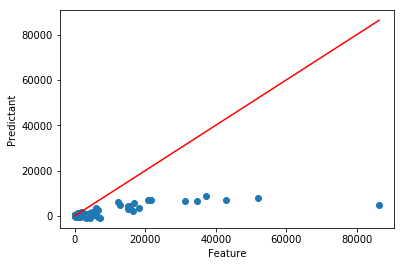

Feature is num_tweets


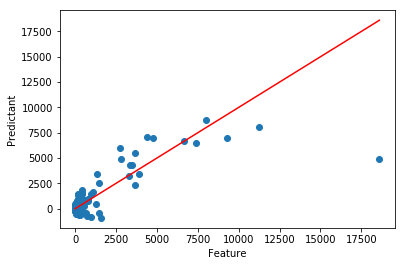

Feature is author


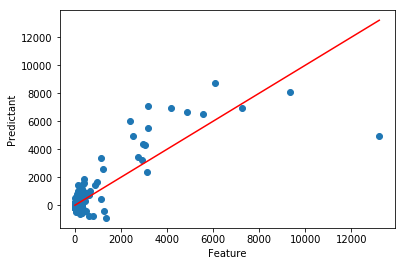

For gohawks file
The R-square score is
 0.7058025721905781

The mean_square_error is
 426270.5420945593

The sorted feature from the most important to the least important according to p value is
 ['num_rank', 'num_tweets', 'author', 'num_favorites', 'max_favorites', 'num_urls', 'num_mentions', 'num_followers', 'max_hashtags', 'max_rank', 'max_followers', 'max_urls', 'num_retweets', 'num_replies', 'num_impressions', 'num_hashtags', 'max_impressions', 'time', 'max_replies', 'max_mentions']

The sorted features p value is
 [2.4182648866985857e-39, 3.1324881405437046e-39, 1.0513542974057127e-11, 7.451442835455778e-08, 8.885337688099035e-08, 1.8449001836039033e-07, 2.293820242248824e-05, 0.0007613296016471795, 0.04016411476807877, 0.12195340594993676, 0.17568419765489215, 0.17822690075197933, 0.28168772885510096, 0.32379484938378067, 0.37066831525196764, 0.48348074082198833, 0.7155889360862348, 0.7179385420288285, 0.7700954814500073, 0.8068585945294927]

The sorted feature from the most imp

In [55]:
#gohawks
#extract feature map
feature_map=readfile_lr_morefeatures('tweets_#gohawks.txt')
#evaluation and analysis
r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map)
print('For gohawks file')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

Feature is num_urls


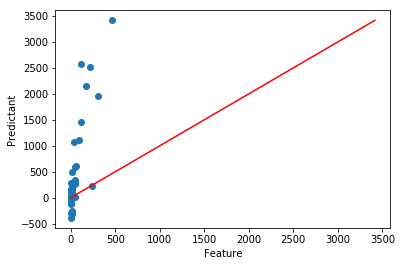

Feature is num_retweets


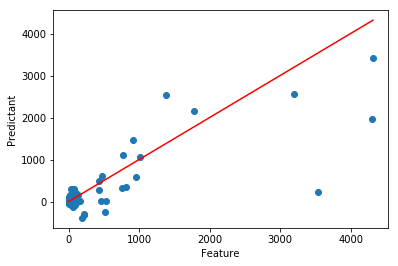

Feature is num_rank


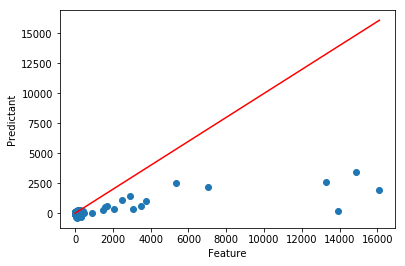

For gopatriots file
The R-square score is
 0.9208902901553064

The mean_square_error is
 5888.186835145955

The sorted feature from the most important to the least important according to p value is
 ['num_urls', 'num_retweets', 'num_rank', 'num_tweets', 'max_replies', 'num_replies', 'num_mentions', 'max_followers', 'max_impressions', 'num_followers', 'num_impressions', 'author', 'max_favorites', 'max_urls', 'num_hashtags', 'time', 'max_hashtags', 'num_favorites', 'max_rank', 'max_mentions']

The sorted features p value is
 [2.1579872484470725e-48, 1.559751625896136e-33, 8.924596649222255e-29, 2.040513980093269e-17, 7.975926850160952e-14, 9.49829825334963e-14, 5.924500187941855e-12, 8.179121100785431e-10, 3.414357972300042e-09, 4.89955262930867e-08, 1.2684924081635534e-07, 1.0686548630390627e-06, 0.0013997240634775854, 0.014835443164589247, 0.017861169093753973, 0.08273867504873467, 0.5483984897446953, 0.6200461133784217, 0.6769642679382329, 0.9123071726551549]

The sorted feature from 

In [44]:
#gopatriots
#extract feature map
feature_map=readfile_lr_morefeatures('tweets_#gopatriots.txt')
#evaluation and analysis
r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map)
print('For gopatriots file')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

Feature is num_hashtags


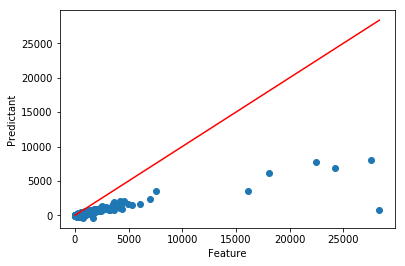

Feature is author


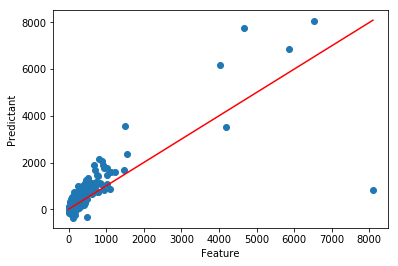

Feature is num_mentions


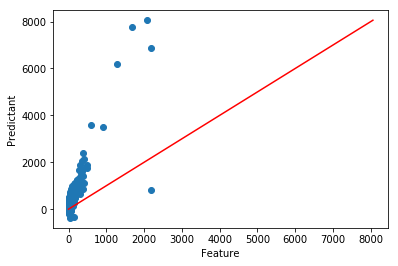

For nfl file
The R-square score is
 0.7665738534591374

The mean_square_error is
 146847.9995139348

The sorted feature from the most important to the least important according to p value is
 ['num_hashtags', 'author', 'num_mentions', 'num_retweets', 'num_rank', 'num_tweets', 'max_replies', 'num_replies', 'max_favorites', 'max_mentions', 'time', 'max_rank', 'num_followers', 'max_followers', 'max_hashtags', 'num_urls', 'num_impressions', 'num_favorites', 'max_impressions', 'max_urls']

The sorted features p value is
 [6.234996221857589e-15, 5.844897979319006e-11, 2.466723605337818e-08, 0.004340954156646907, 0.06572045973442672, 0.07391204622440846, 0.08402133515676798, 0.09412140602530673, 0.09799550786597906, 0.10612579795115053, 0.19644661966281576, 0.21410303441534198, 0.31369157470207365, 0.39901252093903794, 0.6408016336883001, 0.6670272692724923, 0.6994330459802938, 0.8229499066586374, 0.8459919544014148, 0.884297573615461]

The sorted feature from the most important to the least 

In [45]:
#nfl
#extract feature map
feature_map=readfile_lr_morefeatures('tweets_#nfl.txt')
#evaluation and analysis
r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map)
print('For nfl file')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

Feature is num_tweets


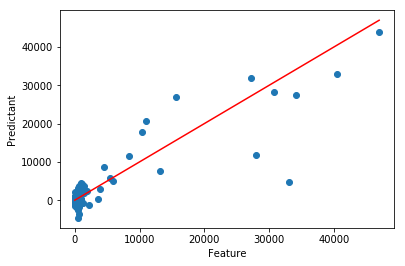

Feature is num_rank


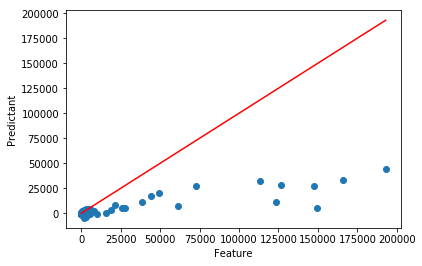

Feature is num_hashtags


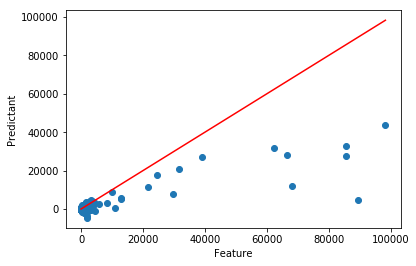

For nfl file
The R-square score is
 0.8374218769397785

The mean_square_error is
 2540292.9562564297

The sorted feature from the most important to the least important according to p value is
 ['num_tweets', 'num_rank', 'num_hashtags', 'author', 'num_mentions', 'num_replies', 'num_followers', 'max_followers', 'max_replies', 'num_impressions', 'max_impressions', 'num_retweets', 'num_favorites', 'max_rank', 'max_mentions', 'max_favorites', 'max_urls', 'max_hashtags', 'time', 'num_urls']

The sorted features p value is
 [8.925358057826604e-50, 1.4538417801654755e-43, 7.886638604114342e-13, 1.2330467749805218e-08, 1.4808463032043119e-08, 6.307812102571342e-06, 9.940480710073796e-06, 2.8318270674944148e-05, 7.139895069694055e-05, 0.00010362429665840404, 0.0006016316281843253, 0.0060880700460563646, 0.26682032896807395, 0.2744645139712801, 0.3270095170128625, 0.4872379166752039, 0.5079809802271216, 0.717997100555497, 0.7482799513888465, 0.8789518913006673]

The sorted feature from the most i

In [46]:
#patriots
#extract feature map
feature_map=readfile_lr_morefeatures('tweets_#patriots.txt')
#evaluation and analysis
r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map)
print('For nfl file')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

Feature is num_tweets


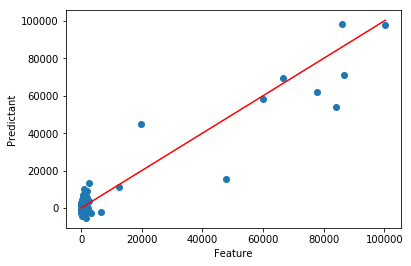

Feature is num_rank


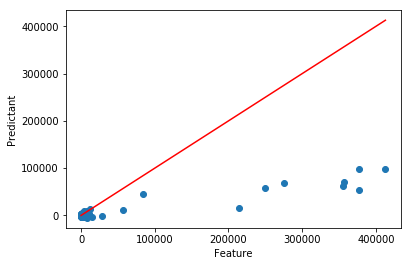

Feature is num_retweets


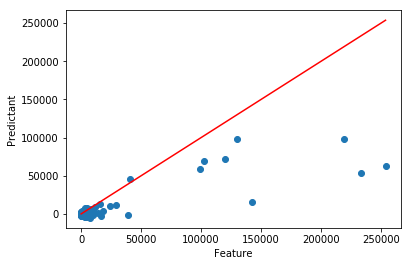

For sb49 file
The R-square score is
 0.874966017932038

The mean_square_error is
 10358241.379883604

The sorted feature from the most important to the least important according to p value is
 ['num_tweets', 'num_rank', 'num_retweets', 'num_replies', 'num_hashtags', 'num_mentions', 'author', 'num_urls', 'max_replies', 'max_favorites', 'num_followers', 'num_impressions', 'max_rank', 'max_mentions', 'max_impressions', 'max_followers', 'time', 'num_favorites', 'max_urls', 'max_hashtags']

The sorted features p value is
 [2.084156522733939e-30, 4.631375516441027e-27, 8.697633193685819e-10, 9.974327554268621e-10, 8.404634771265356e-09, 6.617781484847027e-08, 9.720753350625387e-05, 0.00029434981136578295, 0.00033912303228778647, 0.008455114103494922, 0.03150845829896889, 0.09731114404223885, 0.2856786372718445, 0.3018983450367237, 0.5453462635094999, 0.5757040874710118, 0.6829987573689544, 0.7693351857319477, 0.9388429724156366, 0.9550032577021738]

The sorted feature from the most important

In [47]:
#sb49
#extract feature map
feature_map=readfile_lr_morefeatures('tweets_#sb49.txt')
#evaluation and analysis
r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map)
print('For sb49 file')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))

Feature is num_hashtags


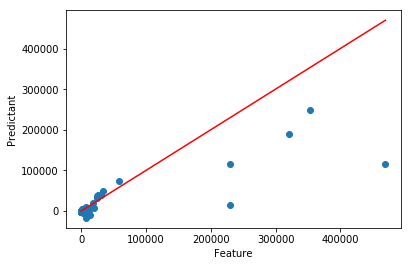

Feature is num_favorites


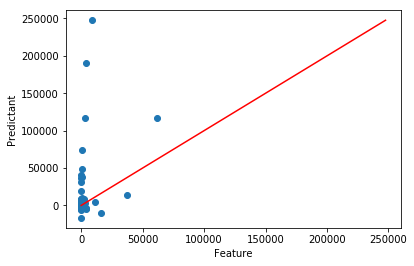

Feature is num_replies


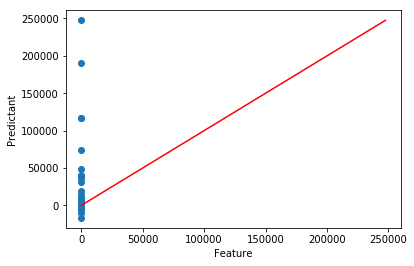

For superbowl file
The R-square score is
 0.9017270303486117

The mean_square_error is
 25767955.515159484

The sorted feature from the most important to the least important according to p value is
 ['num_hashtags', 'num_favorites', 'num_replies', 'max_favorites', 'num_tweets', 'num_rank', 'num_urls', 'max_replies', 'max_urls', 'num_impressions', 'max_impressions', 'max_mentions', 'num_followers', 'max_rank', 'max_followers', 'time', 'author', 'num_retweets', 'max_hashtags', 'num_mentions']

The sorted features p value is
 [1.638548898374419e-10, 1.043901370738758e-07, 9.96067053392394e-07, 1.3654799774105642e-05, 0.00026880192299385565, 0.0012124433616328507, 0.0050558166179479926, 0.005468180240798211, 0.08085159600018231, 0.21903135620019784, 0.2884287555988829, 0.3522959233736954, 0.38826987999067797, 0.5076625764991354, 0.5155928534462708, 0.57408808752369, 0.7856142560587385, 0.8590017876702717, 0.967974644827194, 0.9788043143929952]

The sorted feature from the most important to

In [48]:
#superbowl
#extract feature map
feature_map=readfile_lr_morefeatures('tweets_#superbowl.txt')
#evaluation and analysis
r2, mse, sort_p_score, sort_feature_name, sort_t_score,sort_feature_name_t,results=ols_morefeatures(feature_map)
print('For superbowl file')
print('The R-square score is\n {}\n'.format(r2))
print('The mean_square_error is\n {}\n'.format(mse))
print('The sorted feature from the most important to the least important according to p value is\n {}\n'.format(sort_feature_name))
print('The sorted features p value is\n {}\n'.format(sort_p_score))
print('The sorted feature from the most important to the least important according to t value is\n {}\n'.format(sort_feature_name_t))
print('The sorted features t value is\n {}'.format(sort_t_score))